# **1. Recommender System Introduction & Workflow**

---
## Outline:

1. Background
2. Simplified Workflows.
3. Importing Data
4. Find Top-$k$ Recommendations
5. Data Preparations
6. Data Preprocessing
7. Modeling
8. Decision Process (Recommendation Process)

# **Background**
---

## Problem Description
---

- A streaming platform **nonton-yuk.com** are having a problem with its user retention.
- In 3 months, the user retention rate dropped almost 15% which really affects **nonton-yuk.com** revenues.
- After doing an urgent user research, **nonton-yuk.com** teams found that **users find it difficult** to browse movie in **nonton-yuk.com** which has nearly ~7,000 movies.

## Business Objective
---

Our business objective would be **increasing user retention** to **15%** (assumed ofcourse) in 3 months.

## Solution
---


- We can create a **movie recommendation** to help **users browse** the movie **easily** --> remove the users difficulty in using **nonton-yuk.com** platform.

Some recommendations approach:
1. **Non-personalized**: recommendation by popularity
2. **Personalized**: collaborative filtering

## Data Description
---

- The data is obtained from [Movielens dataset](https://grouplens.org/datasets/movielens/).
- It contains ~100K ratings from 1,000 users and 1,700 movies.

There are two files that we use:

**The movie rating data** : `rating.csv`

<center>

|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`userId`|The user ID|`int`|
|`movieId`|The movie ID|`int`|
|`rating`|Rating given from user to movie. Ranging from `0` to `5`|`float`|



**The movie metadata** : `movies.csv`

<center>

|Features|Descriptions|Data Type|
|:--|:--|:--:|
|`movieId`|The movie ID|`int`|
|`title`|The movie ID title|`str`|
|`genres`|The movie ID genres|`str`|

# **Recommender System Workflow** (Simplified)
---

## 1. Importing Data

1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

## 2. Non personalized recommendations

1. Get the movie-rating aggregate data
2. Extract the top k, most rated movie

## 3. Personalized recommendations

1. Create a Utility Matrix
2. Split Train-Test
3. Train & Find the Best Model
4. Evaluation

## 4. Personalized recommendations: Predictions

1. Predict recommendation of user-i to unrated item-j
2. Predict recommendation of user-i to all their unrated items

# **1. Importing Data**
---

What do we do?
1. Load the data.
2. Check the shape & type of data.
3. Handle the duplicates data to maintain data validity.

## Load the data

In [1]:
# Load this library
import numpy as np
import pandas as pd

Load the data from given data path

In [2]:
rating_path = '../data/ratings.csv'

In [3]:
rating_data = pd.read_csv(rating_path,
                          delimiter = ',')

In [4]:
rating_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Check data shapes & types

In [5]:
# Check data shapes
rating_data.shape

(100836, 4)

The data has 4 feature with ~100,000 user rating recorded.

In [6]:
# Check data types
rating_data.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

Correct features type: `userId`, `movieId`, and `rating`

Wait, we do not need `timestamp` features for now, so we drop it.

In [7]:
# Drop timestamp
rating_data_dropped = rating_data.drop(columns=['timestamp'], axis=1)

# Validate
assert len(rating_data_dropped.columns) == 3
assert rating_data_dropped.columns.tolist() == ['userId', 'movieId', 'rating']
assert len(rating_data_dropped) == len(rating_data)

In [8]:
rating_data_dropped.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [9]:
rating_data_dropped.shape

(100836, 3)

## Handling duplicates data


We need to check that there is no user ID that rates similar movie ID more than one.

In [10]:
# Check duplicate data
rating_data_dropped.duplicated(subset=['userId', 'movieId']).sum()

0

Great! Our data is free from duplicate rates.

**Note**
- If you have a user ID rates similar movie ID more than one, you can keep the most up to date ones & drop the rest.

## Create load function

Finally, we can create load data function

In [11]:
def load_rating_data(rating_path):
    """
    Function to load data & remove from duplicates

    Parameters
    ----------
    rating_path : str
        The path of rating data

    Returns
    -------
    rating_data : pandas DataFrame
        The sample of rating data
    """
    # Load data
    rating_data_raw = pd.read_csv(rating_path, delimiter=',')
    print('Original data shape :', rating_data_raw.shape)

    # Drop timestamp
    rating_data = rating_data_raw.drop(columns=['timestamp'], axis=1)
    print('Dropped data shape  :', rating_data.shape)

    return rating_data


In [12]:
# Load rating data
rating_data = load_rating_data(rating_path = rating_path)

Original data shape : (100836, 4)
Dropped data shape  : (100836, 3)


In [13]:
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


# **2. Non-Personalized Recommender Systems** : Top Rating Approach
---

This is the most easiest way to recommend movies for our user, i.e. by recommending movies that was rated the most by users.

## How do we do that?
---

Easy, you find rating aggregate (count of rating) for each movie Id.

But how?
1. Group by the `rating_data` by `movieId`
2. Then take aggregate `count` from `rating` column. With this you know how many users have rated the movie.
3. Sort the results from highest to lowest count rating.
4. Retrieve the top $k$ most rated `movieId`.

## Get the movie-rating aggregate data
---

**First**, group by the `rating_data` by `movieId` and aggregate its counts.

In [14]:
# Group by & aggregate
rating_data_grouped = rating_data.groupby('movieId', as_index=False)

rating_data_grouped.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100823,610,160836,3.0
100825,610,161634,4.0
100827,610,163937,3.5
100828,610,163981,3.5


**Then**, aggregate the previous data by `counts` to find how many rating that a `movieId` receives?

In [15]:
# Group by & aggregate
rating_data_agg = rating_data_grouped.agg(
                    rating_count=pd.NamedAgg(column='rating',
                                             aggfunc='count')
                  )

rating_data_agg.head()

,movieId,rating_count
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [16]:
rating_data_agg.shape

(9724, 2)

**Next**, we sort the rating count in descending order (high to low order)

In [17]:
rating_data_sorted = rating_data_agg.sort_values('rating_count',
                                                 ascending=False)

rating_data_sorted.head()

,movieId,rating_count
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278


In [18]:
rating_data_sorted.shape

(9724, 2)

**A fast way** to create previous steps are

In [19]:
# Groupby, aggregate, and sort data
rating_data_grouped = (rating_data
                            .groupby('movieId', as_index=False)
                            .agg(rating_count=pd.NamedAgg(column='rating',
                                                          aggfunc='count'))
                            .sort_values('rating_count', ascending=False)
                       )


# Print shape
print('Sorted grouped rating data shape :', rating_data_grouped.shape)
rating_data_grouped.head()

Sorted grouped rating data shape : (9724, 2)


,movieId,rating_count
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278


Create the function

In [20]:
def get_aggregate_data(rating_data):
    """
    Get the aggregate of rating data.
        1. Group by data by movieId
        2. Count number of rating given to each movieId

    Parameters
    ----------
    rating_data : pandas DataFrame
        The rating data sample

    Returns
    -------
    rating_data_grouped : pandas DataFrame
        The grouped rating data
    """
    # Groupby, aggregate, and sort data
    rating_data_grouped = (rating_data
                                .groupby('movieId', as_index=False)
                                .agg(
                                    rating_count=pd.NamedAgg(column='rating',
                                                            aggfunc='count'))
                                .sort_values('rating_count', ascending=False))

    # Print shape
    print('Sorted grouped rating data shape :', rating_data_grouped.shape)

    return rating_data_grouped

In [21]:
# Get the grouped rating data
rating_data_grouped = get_aggregate_data(rating_data = rating_data)

rating_data_grouped.head()

Sorted grouped rating data shape : (9724, 2)


,movieId,rating_count
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278


## Extract the top $k$ most rated movie
---

From the previous process, we can find the top $k$ most rated movie

In [22]:
# Say we want to extract top 10 most rated movie
k = 10

# Extract
top_k_movies = rating_data_grouped.head(k).copy()
top_k_movies

,movieId,rating_count
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278
224,260,251
418,480,238
97,110,237
507,589,224
461,527,220


It's nice, but we do not know what movie on each `movieId`. We need to extract the movie title for each `movieId`

Let's load the movie metadata files

In [23]:
def load_movie_data(movie_path):
    """
    Load movie data from the given path

    Parameters
    ----------
    movie_path : str
        The movie data path

    Returns
    -------
    movie_data : pandas DataFrame
        The movie metadata
    """
    # Load data
    movie_data = pd.read_csv(movie_path,
                             index_col='movieId',
                             delimiter=',')

    print('Movie data shape :', movie_data.shape)
    return movie_data


In [24]:
# Define the movie path
movie_path = '../data/movies.csv'

In [25]:
# Load movie data
movie_data = load_movie_data(movie_path = movie_path)

movie_data.head()

Movie data shape : (9742, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


Finally, we can extract the title of the `top_k_movies`

In [26]:
top_k_movies['title'] = movie_data.loc[top_k_movies['movieId'], 'title'].tolist()
top_k_movies['genres'] = movie_data.loc[top_k_movies['movieId'], 'genres'].tolist()
top_k_movies

,movieId,rating_count,title,genres
314,356,329,Forrest Gump (1994),Comedy|Drama|Romance|War
277,318,317,"Shawshank Redemption, The (1994)",Crime|Drama
257,296,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
510,593,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1938,2571,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller
224,260,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
418,480,238,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
97,110,237,Braveheart (1995),Action|Drama|War
507,589,224,Terminator 2: Judgment Day (1991),Action|Sci-Fi
461,527,220,Schindler's List (1993),Drama|War


Nice, we can see get the top 10 most rated movie (even though they are old movies)

## Create get top rated movies functions
---

Let's summarize all of our code

In [27]:
# get the top K most rated movie
def get_top_rated_movie(k, rating_data_grouped, movie_data):
    """
    Get the top k most rated movie

    Parameters
    ----------
    k : int
        Number of top k most rated movie

    rating_data_grouped : pandas DataFrame
        The grouped rating data

    movie_data : pandas DataFrame
        The movie metadata (contains movie title)

    Returns
    -------
    top_movies_data : pandas DataFrame
        The top k movies data
    """
    # Extract the top k most rated movie
    top_movies = rating_data_grouped.head(k).copy()

    # Add the title
    top_movies['title'] = movie_data.loc[top_movies['movieId'], 'title'].tolist()
    top_movies['genres'] = movie_data.loc[top_movies['movieId'], 'genres'].tolist()

    print(f'The top {k} most rated movie shape :', top_movies.shape)
    return top_movies


In [28]:
top_movies = get_top_rated_movie(k = 10,
                                 rating_data_grouped = rating_data_grouped,
                                 movie_data = movie_data)

top_movies

The top 10 most rated movie shape : (10, 4)


,movieId,rating_count,title,genres
314,356,329,Forrest Gump (1994),Comedy|Drama|Romance|War
277,318,317,"Shawshank Redemption, The (1994)",Crime|Drama
257,296,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
510,593,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1938,2571,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller
224,260,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
418,480,238,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
97,110,237,Braveheart (1995),Action|Drama|War
507,589,224,Terminator 2: Judgment Day (1991),Action|Sci-Fi
461,527,220,Schindler's List (1993),Drama|War


Nice!

Let's recreate the whole process

In [29]:
# Generate grouped rating data
rating_data_grouped = get_aggregate_data(rating_data = rating_data)

rating_data_grouped.head()

Sorted grouped rating data shape : (9724, 2)


,movieId,rating_count
314,356,329
277,318,317
257,296,307
510,593,279
1938,2571,278


In [30]:
# Load movie data
movie_data = load_movie_data(movie_path = movie_path)

movie_data.head()

Movie data shape : (9742, 2)


,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [31]:
# Get the top 5 recommendations
top_movies = get_top_rated_movie(k = 5,
                                 rating_data_grouped = rating_data_grouped,
                                 movie_data = movie_data)

top_movies

The top 5 most rated movie shape : (5, 4)


,movieId,rating_count,title,genres
314,356,329,Forrest Gump (1994),Comedy|Drama|Romance|War
277,318,317,"Shawshank Redemption, The (1994)",Crime|Drama
257,296,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
510,593,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
1938,2571,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller


We can visualize the top rated movies

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

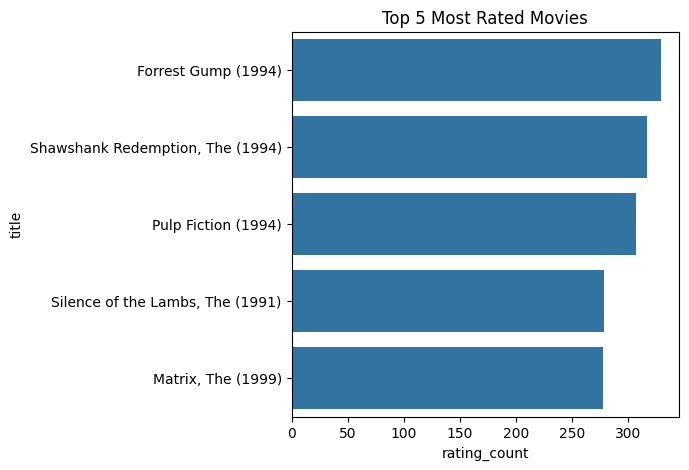

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

sns.barplot(data = top_movies,
            x = 'rating_count',
            y = 'title',
            color = 'tab:blue',
            ax = ax)

plt.title('Top 5 Most Rated Movies')
plt.show()

Finally, we've made our top $k$ recommendation systems by the most rated movies.

What do you think? **Would it be enough to increase the user retention if we recommend these movies to all users?**

# **3. Personalized Recommender Systems**: Collaborative Filtering
---

## Background
---

One drawback from a non-personalized RecSys is **user** might dislikes the recommendations.

e.g.
- You might **dislike** horror movie recommendation if you **like** action more.

In reality, each user has their own movie preferences. So, what if we can create a RecSys that personalized to each user? Baam! A **personalized RecSys** via collaborative filtering.

To build a personalized RecSys, you can start by creating a **user-rating** or **utility** matrix.

<center>

<image src="../assets/user_film_matrix.png">
<br>
<a href="https://thecattlecrew.net">Source: The Calttle Crew</a>

</center>

- The utility matrix store the rating (utility) from users to items (read: movies).
- The shape of utility matrix is `(#users x #items)`. If you have 500 users with 2,000 movies, your utility matrix shape should be `(500, 2000)`
- The value of `5, 1, 3, 5, 4, 3, ...` is the rating that is given by users to movies.
- What is `?` ? It means that user-`i` haven't rate movie-`j` yet.



- From the utility matrix, we can get the characters of each user or each items.
- From user and item characters, we can create a personalized recommendations.


**Sparse Matrix**

---

- Utility matrix is a sparse matrix (only small % of utility matrix are filled with utility value)

<center>

<image src="../assets/sparse_matrix.png">
<br>
<a href="https://cmdlinetips.com/">Source: The CMD Line Tips</a>

</center>

**Problems**:
- If you create a full-shaped utility matrix, it needs **a lot of memory** to save and operate.


**Solutions**:
- We can use other matrix format to define the utility matrix.
  1. COO
  2. CSR


**COO matrix format**

---

- It map the non-zero values by storing its position (row and columns).

<center>

<image src="../assets/coo.gif">
<br>
<a href="https://matteding.github.io/">Source: The Matt Eding Github</a>

</center>

## Workflow
---

To create a personalized RecSys, we can follow these steps:

```
1. Data Preparation --> Create utility matrix & Split Train-Test
2. Data Preprocessing --> Handling missing values
3. Train recommendation model --> Baseline, Neighbor-based (K-NN) & Matrix Factorization (SVD-like)
```

## Data Preparation : Create Utility Matrix & Split Train-Test
---

### Create Utility Matrix in COO format

For now, we create the utility matrix in COO format easily using `SciPy` library.

In [34]:
# Load library
from scipy.sparse import coo_matrix

In [35]:
# Prepare the data
row = rating_data['userId'].values
col = rating_data['movieId'].values
data = rating_data['rating'].values

In [36]:
# Create the utility matrix in COO format
coo_data = coo_matrix((data, (row, col)))
print(coo_data)

  (1, 1)	4.0
  (1, 3)	4.0
  (1, 6)	4.0
  (1, 47)	5.0
  (1, 50)	5.0
  (1, 70)	3.0
  (1, 101)	5.0
  (1, 110)	4.0
  (1, 151)	5.0
  (1, 157)	5.0
  (1, 163)	5.0
  (1, 216)	5.0
  (1, 223)	3.0
  (1, 231)	5.0
  (1, 235)	4.0
  (1, 260)	5.0
  (1, 296)	3.0
  (1, 316)	3.0
  (1, 333)	5.0
  (1, 349)	4.0
  (1, 356)	4.0
  (1, 362)	5.0
  (1, 367)	4.0
  (1, 423)	3.0
  (1, 441)	4.0
  :	:
  (610, 156371)	5.0
  (610, 156726)	4.5
  (610, 157296)	4.0
  (610, 158238)	5.0
  (610, 158721)	3.5
  (610, 158872)	3.5
  (610, 158956)	3.0
  (610, 159093)	3.0
  (610, 160080)	3.0
  (610, 160341)	2.5
  (610, 160527)	4.5
  (610, 160571)	3.0
  (610, 160836)	3.0
  (610, 161582)	4.0
  (610, 161634)	4.0
  (610, 162350)	3.5
  (610, 163937)	3.5
  (610, 163981)	3.5
  (610, 164179)	5.0
  (610, 166528)	4.0
  (610, 166534)	4.0
  (610, 168248)	5.0
  (610, 168250)	5.0
  (610, 168252)	5.0
  (610, 170875)	3.0


`coo_matrix` has several attributes:
1. `.data` --> get the matrix value
2. `.row` --> get the row index, in this context, userId
3. `.col` --> get the col index, in this context, movieId
4. `.nnz` --> get the matrix value

In [37]:
coo_data.data, len(coo_data.data)

(array([4., 4., 4., ..., 5., 5., 3.]), 100836)

In [38]:
coo_data.row

array([  1,   1,   1, ..., 610, 610, 610], dtype=int32)

In [39]:
coo_data.col

array([     1,      3,      6, ..., 168250, 168252, 170875], dtype=int32)

In [40]:
coo_data.nnz

100836

Let's create a function

In [41]:
def get_utility_matrix(rating_data):
    """
    Get a COO format utility matrix

    Parameters
    ----------
    rating_data : pandas DataFrame
        The sample of rating data

    Returns
    -------
    coo_data : scipy COO format
        The utility matrix in COO format
    """
    # Prepare the data
    row = rating_data['userId'].values
    col = rating_data['movieId'].values
    data = rating_data['rating'].values

    # Create the utility matrix in COO format
    coo_data = coo_matrix((data, (row, col)))

    return coo_data


In [42]:
coo_data = get_utility_matrix(rating_data = rating_data)
coo_data

<611x193610 sparse matrix of type '<class 'numpy.float64'>'
	with 100836 stored elements in COOrdinate format>

### Split Train-Test

- To ensure that our model is **learning** not **memorizing**, we need to evaluate the model with a set of **unseen** data.

- Problem: we do not have set of **unseen** data

- Solution:
  - We split our current data to Train & Test set.
  - We train the model in Train set.
  - We evaluate the model performance in Test set.

How do we do the splitting?
- Split the data randomly based on non-missing rating.
- Split size proportion --> train : test = 80% : 20%

In [43]:
# Define the test size
test_size = 0.2

In [44]:
# Generate random seed for reproducibility
np.random.seed(42)

# Shuffle rating data
raw_index = rating_data.index.tolist().copy()
np.random.shuffle(raw_index)

# Define the threshold
threshold = int((1-test_size) * len(raw_index))

# Split the index
train_index = raw_index[:threshold]
test_index = raw_index[threshold:]

#print(train_index)
#print(test_index)

In [45]:
# Next, extract the train & test data based on test mask
coo_data_train = get_utility_matrix(rating_data = rating_data.loc[train_index])
coo_data_test = get_utility_matrix(rating_data = rating_data.loc[test_index])

In [46]:
# Validate shape of non-missing rating
coo_data_train.nnz, coo_data_test.nnz

(80668, 20168)

Great! The test data set should be 20% of whole data.

Let's create all the functions

In [47]:
def split_train_test(rating_data, test_size=0.2, random_state=42):
    """
    Function to create train & test utility matrix in COO format

    Parameters
    ----------
    rating_data : pandas DataFrame
        The rating data

    test_size : float, default=0.2
        The test size

    random_state : int, default=42
        For reproducibility
    """
    # Generate random seed for reproducibility
    np.random.seed(random_state)

    # Shuffle rating data
    raw_index = rating_data.index.tolist().copy()
    np.random.shuffle(raw_index)

    # Define the threshold
    threshold = int((1-test_size) * len(raw_index))

    # Split the index
    train_index = raw_index[:threshold]
    test_index = raw_index[threshold:]

    # Next, extract the train & test data based on test mask
    coo_data_train = get_utility_matrix(rating_data = rating_data.loc[train_index])
    coo_data_test = get_utility_matrix(rating_data = rating_data.loc[test_index])

    # validate
    print('Train, Test shape:', (coo_data_train.nnz, coo_data_test.nnz))

    return coo_data_train, coo_data_test


In [48]:
# Split the data
coo_data_train, coo_data_test = split_train_test(rating_data = rating_data,
                                                 test_size = 0.2,
                                                 random_state = 42)

Train, Test shape: (80668, 20168)


In [49]:
# utility train shape
coo_data_train.shape

(611, 193610)

In [50]:
# utility test shape
coo_data_test.shape

(611, 193586)

If your data has been splitted, you can
- Process the **Train** data
- Model in the **Train** data
- and Evaluate in the **Test** data

## Data Preprocessing
---

**Missing Value Imputation**

Eventough our utility matrix contains **a lot** of missing value. In our current (next) approach in Non-Personalized Recommender System only recommend popular items. Not Through Learning Process such as : Optimization,etc.

We don't need yet to impute missing values

## Train Recommender System Models
---

There are many models to use. In this class we will use:
1. Baseline Recomennder System (Mean for All global rating)
1. Neighbourhood Based Recommender System
2. SVD-like Recommender System

**How do those models work?**

Easy! We will cover it on the next course. Now, we focus on workflow of modeling.

**Note on Surprise Library**

To model the personalized RecSys, we will use a well-defined library called with `surprise`. See the [Surprise Docs.](https://surprise.readthedocs.io/en/stable/index.html)

Then load the library

In [51]:
import surprise

Now let's start modeling.

### Load the Data
---

Why we do this **again**? Because we works on a specific library that need specific input format.

So, let's do this

In [52]:
# Import some library
from surprise import Dataset, Reader

Initiate the rating scale

In [53]:
reader = Reader(rating_scale = (1, 5))
reader

Initiate the data. It must be on format `userId`, `itemId`, and `ratings`, respectively.

In [54]:
utility_data = Dataset.load_from_df(
                    df = rating_data[['userId', 'movieId', 'rating']].copy(),
                    reader = reader
                )

utility_data

Let's print the data

In [55]:
utility_data.df.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [56]:
rating_data.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Nice! we have similar dataset

### Split Train-Test
---

We then split the train-test data. We use the similar logic from previous section

In [57]:
# Load library for deep copy
import copy

In [58]:
# Create a function
def train_test_split(utility_data, test_size, random_state):
    """
    Train test split the data
    ref: https://surprise.readthedocs.io/en/stable/FAQ.html#split-data-for-unbiased-estimation-py

    Parameters
    ----------
    utility_data : Surprise utility data
        The sample of whole data set

    test_size : float, default=0.2
        The test size

    random_state : int, default=42
        For reproducibility

    Returns
    -------
    full_data : Surprise utility data
        The new utility data

    train_data : Surprise format
        The train data

    test_data : Surprise format
        The test data
    """
    # Deep copy the utility_data
    full_data = copy.deepcopy(utility_data)

    # Generate random seed
    np.random.seed(random_state)

    # Shuffle the raw_ratings for reproducibility
    raw_ratings = full_data.raw_ratings
    np.random.shuffle(raw_ratings)

    # Define the threshold
    threshold = int((1-test_size) * len(raw_ratings))

    # Split the data
    train_raw_ratings = raw_ratings[:threshold]
    test_raw_ratings = raw_ratings[threshold:]

    # Get the data
    full_data.raw_ratings = train_raw_ratings
    train_data = full_data.build_full_trainset()
    test_data = full_data.construct_testset(test_raw_ratings)

    return full_data, train_data, test_data


In [59]:
# Split the data
full_data, train_data, test_data = train_test_split(utility_data,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [60]:
# Validate the splitting
train_data.n_ratings, len(test_data)

(80668, 20168)

Great! The test size is around 20% of all dataset

Now we are ready to create the model.

### Create the Model
---

We want to create two models & get the best model.

To do that, we need to perform a cross validation thus we evaluate the model objectively.

In [61]:
# Load the model library
# i.e. Baseline, KNN, and SVD
from surprise import AlgoBase, KNNBasic, SVD

Then, create the model object

Our Baseline Model just simply predict ratings using mean from all training data provided to model .

Since `surprise` library does not provide mean prediction model , we have to create custom algorithm first.

Guide `https://surprise.readthedocs.io/en/stable/building_custom_algo.html`

In [62]:
class MeanPrediction(AlgoBase):
    '''Baseline prediction. Return global mean as prediction'''
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        '''Fit the train data'''
        AlgoBase.fit(self, trainset)

    def estimate(self, u, i):
        '''Perform the estimation/prediction.'''
        est = self.trainset.global_mean
        return est

In [63]:
# Create baseline model
model_baseline = MeanPrediction()
model_baseline

In [64]:
# Create Neighbor-based model -- K-Nearest Neighbor
model_knn = KNNBasic(random_state=42)
model_knn

In [65]:
# Create matrix factorization model -- SVD-like
model_svd = SVD(n_factors=100, random_state=42)
model_svd

Next, fit & cross-validate the model.

### Find the Best Model with Cross-Validation
---

In [66]:
# Import the cross validation module
from surprise.model_selection import cross_validate

To perform cross validate
`cross_validate(algo, data, cv, measures)`

1. `algo` = Surprise model
2. `data` = Surprise format data
3. `cv` = number of fold of cross validation
4. `measures` = metric to measure model performance



First, we will do a $5$-fold cross validation. Next, we measure the performance using RMSE metric because we want to predict the rating (continuous data type)

**Baseline** model

In [67]:
# Use full_data for cross validation
# Your results could be different because
# there is no random seed stated within this functions
cv_baseline = cross_validate(algo = model_baseline,
                             data = full_data,
                             cv = 5,
                             measures = ['rmse'])

In [68]:
# Extract CV results
cv_baseline_rmse = cv_baseline['test_rmse'].mean()
cv_baseline_rmse

1.0420126162986096

**K-Nearest Neighbor** model

In [69]:
cv_knn = cross_validate(algo = model_knn,
                        data = full_data,
                        cv = 5,
                        measures = ['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [70]:
# Extract CV results
cv_knn_rmse = cv_knn['test_rmse'].mean()
cv_knn_rmse

0.9589057865687737

**SVD-like** model

In [71]:
cv_svd = cross_validate(algo = model_svd,
                        data = full_data,
                        cv = 5,
                        measures = ['rmse'])

In [72]:
# Extract CV results
cv_svd_rmse = cv_svd['test_rmse'].mean()
cv_svd_rmse

0.8793607027046333

**Performance comparison**

We can summarize the performance

In [73]:
summary_df = pd.DataFrame({'Model': ['Baseline', 'KNN', 'SVD'],
                           'CV Performance - RMSE': [cv_baseline_rmse, cv_knn_rmse, cv_svd_rmse]})

summary_df

,Model,CV Performance - RMSE
0,Baseline,1.042013
1,KNN,0.958906
2,SVD,0.879361


The best model is **SVD** with better CV performance, i.e. lower RMSE

Finally, we retrain the SVD model with the whole train dataset

In [74]:
# Create object
model_best = SVD(n_factors=100, random_state=42)

# Retrain on whole train dataset
model_best.fit(train_data)

### Evaluate the Best Model
---

After finding the best model, we can sanity check the performance on the test dataset

In [75]:
# import performance library
from surprise import accuracy

Next, we predict the test set using our best model

In [76]:
test_pred = model_best.test(test_data)
test_rmse = accuracy.rmse(test_pred)
test_rmse

RMSE: 0.8807


0.8807462819979623

To summarize

In [77]:
summary_test_df = pd.DataFrame({'Model' : ['SVD'],
                                'RMSE-CV': [cv_svd_rmse],
                                'RMSE-Test': [test_rmse]})

summary_test_df

,Model,RMSE-CV,RMSE-Test
0,SVD,0.879361,0.880746


Great predictions!

# **4. Personalized Recommender Systems**: Predictions
---

Decision Process is to recommend items to user
from our trained model

<image src="../assets/applsci-10-05510-g001.webp" image>




1. SVD Like-Recommender System
The Model will lookup latent factor (vector) both movie and user factor based on its' userId and movieId. Rating prediction would be multiplication between user factor and item factor. After that the predicted rating will be ordered and will be picked Top K Highest Predicted rating and recommend the movie to user.

Also if user already seen a movie it could be removed.


## Predict with Best Model : SVD-Like Recommender System

In [78]:
# Recommendation based on SVD-like Recommender System Model
# We will try to recommend on sample userid ,userId 1 & 99

# We can use model_best.predict method
help(model_best.predict)

Help on method predict in module surprise.prediction_algorithms.algo_base:

predict(uid, iid, r_ui=None, clip=True, verbose=False) method of surprise.prediction_algorithms.matrix_factorization.SVD instance
    Compute the rating prediction for given user and item.
    
    The ``predict`` method converts raw ids to inner ids and then calls the
    ``estimate`` method which is defined in every derived class. If the
    prediction is impossible (e.g. because the user and/or the item is
    unknown), the prediction is set according to
    :meth:`default_prediction()
    <surprise.prediction_algorithms.algo_base.AlgoBase.default_prediction>`.
    
    Args:
        uid: (Raw) id of the user. See :ref:`this note<raw_inner_note>`.
        iid: (Raw) id of the item. See :ref:`this note<raw_inner_note>`.
        r_ui(float): The true rating :math:`r_{ui}`. Optional, default is
            ``None``.
        clip(bool): Whether to clip the estimation into the rating scale.
            For exampl

`model_best.predict` has argument
- `uid` (i.e., the `userId`) and
- `iid` (i.e., the item ID or `movieId`)

### Let's predict what is the rating of user 9 to movie 10

In [79]:
sample_prediction = model_svd.predict(uid = 9,
                                      iid = 10)

In [80]:
sample_prediction

Prediction(uid=9, iid=10, r_ui=None, est=3.2224705698626694, details={'was_impossible': False})

The results tell us
- `r_ui` : actual rating --> `None`, means user 9 have yet rated movie 10
- `est` : the estimated rating from our model
- `details` : whether prediction is impossible or not. So it's possible to predict.

### Let's predict all the unseen/unrated movie by userId 9

**First, we find the unrated movie id from user id 9**

In [81]:
# Get unique movieId
unique_movie_id = set(rating_data['movieId'])
print(unique_movie_id)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 131098, 31, 32, 131104, 34, 30, 36, 32799, 38, 39, 40, 41, 65577, 43, 44, 45, 46, 47, 48, 65585, 50, 49, 52, 53, 54, 55, 65588, 57, 58, 98361, 60, 61, 62, 65596, 64, 65, 66, 131130, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 163925, 92, 93, 94, 95, 65631, 97, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 32875, 65642, 110, 111, 112, 113, 108, 65651, 116, 117, 118, 119, 121, 122, 123, 32892, 125, 126, 128, 129, 32898, 132, 135, 137, 32906, 140, 141, 163981, 144, 145, 146, 147, 65682, 148, 150, 151, 163985, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 131237, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 98491, 189, 190, 191, 188, 193, 194, 195, 196, 98499, 198, 199, 98503, 201, 65738, 203, 204, 205, 65740, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [82]:
# Get movieId that is rated by user id 9
rated_movie_id = set(rating_data.loc[rating_data['userId']==9, 'movieId'])
print(rated_movie_id)

{3328, 4993, 5378, 5507, 5890, 5891, 5893, 1674, 1037, 5902, 3735, 922, 923, 6044, 4131, 41, 1198, 187, 2877, 5952, 1987, 5956, 5445, 1095, 5447, 5962, 5451, 5965, 4558, 5841, 5843, 2901, 2011, 2012, 223, 5218, 5988, 3173, 2023, 5481, 5872, 6001, 371, 627, 1270, 2300}


In [83]:
# Find unrated movieId
# Use set operation
# unrateddId = wholeId - ratedId
unrated_movie_id = unique_movie_id.difference(rated_movie_id)
print(unrated_movie_id)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 131098, 31, 32, 131104, 34, 30, 36, 32799, 38, 39, 40, 65577, 43, 44, 45, 46, 47, 48, 65585, 50, 49, 52, 53, 54, 55, 65588, 57, 58, 98361, 60, 61, 62, 65596, 64, 65, 66, 131130, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 163925, 92, 93, 94, 95, 65631, 97, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 32875, 65642, 110, 111, 112, 113, 108, 65651, 116, 117, 118, 119, 121, 122, 123, 32892, 125, 126, 128, 129, 32898, 132, 135, 137, 32906, 140, 141, 163981, 144, 145, 146, 147, 65682, 148, 150, 151, 163985, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 131237, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 98491, 189, 190, 191, 188, 193, 194, 195, 196, 98499, 198, 199, 98503, 201, 65738, 203, 204, 205, 65740, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 42, 

In [84]:
# Let's create a function
def get_unrated_item(userid, rating_data):
    """
    Get unrated item id from a user id

    Parameters
    ----------
    userid : int
        The user id

    rating_data : pandas DataFrame
        The rating data

    Returns
    -------
    unrated_item_id : set
        The unrated item id
    """
    # Find the whole item id
    unique_item_id = set(rating_data['movieId'])

    # Find the item id that was rated by user id
    rated_item_id = set(rating_data.loc[rating_data['userId']==userid, 'movieId'])

    # Find the unrated item id
    unrated_item_id = unique_item_id.difference(rated_item_id)

    return unrated_item_id


In [85]:
unrated_movie_id = get_unrated_item(userid=9, rating_data=rating_data)
print(unrated_movie_id)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 131098, 31, 32, 131104, 34, 30, 36, 32799, 38, 39, 40, 65577, 43, 44, 45, 46, 47, 48, 65585, 50, 49, 52, 53, 54, 55, 65588, 57, 58, 98361, 60, 61, 62, 65596, 64, 65, 66, 131130, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 163925, 92, 93, 94, 95, 65631, 97, 96, 99, 100, 101, 102, 103, 104, 105, 106, 107, 32875, 65642, 110, 111, 112, 113, 108, 65651, 116, 117, 118, 119, 121, 122, 123, 32892, 125, 126, 128, 129, 32898, 132, 135, 137, 32906, 140, 141, 163981, 144, 145, 146, 147, 65682, 148, 150, 151, 163985, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 131237, 166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 98491, 189, 190, 191, 188, 193, 194, 195, 196, 98499, 198, 199, 98503, 201, 65738, 203, 204, 205, 65740, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 42, 

**Then, we create the prediction from the unrated movie**

In [86]:
# Initialize dict
predicted_unrated_movie = {
    'userId': 9,
    'movieId': [],
    'predicted_rating': []
}

predicted_unrated_movie

{'userId': 9, 'movieId': [], 'predicted_rating': []}

In [87]:
# Loop for over all unrated movie Id
for id in unrated_movie_id:
    # Create a prediction
    pred_id = model_best.predict(uid = predicted_unrated_movie['userId'],
                                 iid = id)

    # Append
    predicted_unrated_movie['movieId'].append(id)
    predicted_unrated_movie['predicted_rating'].append(pred_id.est)

In [88]:
# Convert to dataframe
predicted_unrated_movie = pd.DataFrame(predicted_unrated_movie)
predicted_unrated_movie

,userId,movieId,predicted_rating
0,9,1,3.440970
1,9,2,3.178351
2,9,3,2.773542
3,9,4,2.717316
4,9,5,2.850927
...,...,...,...
9673,9,163809,3.129475
9674,9,98279,3.251486
9675,9,32743,3.143775
9676,9,65514,3.274698


Nice! Let's sort the values

In [89]:
# Sort the predicted rating values
predicted_unrated_movie = predicted_unrated_movie.sort_values('predicted_rating',
                                                              ascending = False)

predicted_unrated_movie

,userId,movieId,predicted_rating
244,9,260,4.245551
300,9,318,4.233101
947,9,1104,4.205823
1025,9,1213,4.173759
2910,9,3451,4.144698
...,...,...,...
1967,9,2338,1.907615
3023,9,3593,1.898327
412,9,435,1.887569
4366,9,5323,1.868435


In [90]:
# Let's create this into a function
def get_pred_unrated_item(userid, estimator, unrated_item_id):
    """
    Get the predicted unrated item id from user id

    Parameters
    ----------
    userid : int
        The user id

    estimator : Surprise object
        The estimator

    unrated_item_id : set
        The unrated item id

    Returns
    -------
    pred_data : pandas Dataframe
        The predicted rating of unrated item of user id
    """
    # Initialize dict
    pred_dict = {
        'userId': userid,
        'movieId': [],
        'predicted_rating': []
    }

    # Loop for over all unrated movie Id
    for id in unrated_item_id:
        # Create a prediction
        pred_id = estimator.predict(uid = pred_dict['userId'],
                                    iid = id)

        # Append
        pred_dict['movieId'].append(id)
        pred_dict['predicted_rating'].append(pred_id.est)

    # Create a dataframe
    pred_data = pd.DataFrame(pred_dict).sort_values('predicted_rating',
                                                     ascending = False)

    return pred_data

In [91]:
predicted_unrated_movie = get_pred_unrated_item(userid = 9,
                                                estimator = model_best,
                                                unrated_item_id = unrated_movie_id)

predicted_unrated_movie

,userId,movieId,predicted_rating
244,9,260,4.245551
300,9,318,4.233101
947,9,1104,4.205823
1025,9,1213,4.173759
2910,9,3451,4.144698
...,...,...,...
1967,9,2338,1.907615
3023,9,3593,1.898327
412,9,435,1.887569
4366,9,5323,1.868435


And then we create the top movie predictions

In [92]:
# Pick top k biggest rating
k = 5
top_movies_svd = predicted_unrated_movie.head(k).copy()
top_movies_svd

,userId,movieId,predicted_rating
244,9,260,4.245551
300,9,318,4.233101
947,9,1104,4.205823
1025,9,1213,4.173759
2910,9,3451,4.144698


Finally, we can add the Movie Title

In [93]:
# Add the movie title
top_movies_svd['title'] = movie_data.loc[top_movies['movieId'], 'title'].values
top_movies_svd['genres'] = movie_data.loc[top_movies['movieId'], 'genres'].values

top_movies_svd

,userId,movieId,predicted_rating,title,genres
244,9,260,4.245551,Forrest Gump (1994),Comedy|Drama|Romance|War
300,9,318,4.233101,"Shawshank Redemption, The (1994)",Crime|Drama
947,9,1104,4.205823,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1025,9,1213,4.173759,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
2910,9,3451,4.144698,"Matrix, The (1999)",Action|Sci-Fi|Thriller


Great!
Lets wrap all to a function

In [94]:
def get_top_highest_unrated(estimator, k, userid, rating_data, movie_data):
    """
    Get top k highest of unrated movie from a Surprise estimator RecSys

    Parameters
    ----------
    estimator : Surprise model
        The RecSys model

    k : int
        The number of Recommendations

    userid : int
        The user Id to recommend

    rating_data : pandas Data Frame
        The rating data

    movie_data : pandas DataFrame
        The movie meta data

    Returns
    -------
    top_item_pred : pandas DataFrame
        The top items recommendations
    """
    # 1. Get the unrated item id of a user id
    unrated_item_id = get_unrated_item(userid=userid, rating_data=rating_data)

    # 2. Create prediction from estimator to all unrated item id
    predicted_unrated_item = get_pred_unrated_item(userid = userid,
                                                   estimator = estimator,
                                                   unrated_item_id = unrated_item_id)

    # 3. Sort & add meta data
    top_item_pred = predicted_unrated_item.head(k).copy()
    top_item_pred['title'] = movie_data.loc[top_item_pred['movieId'], 'title'].values
    top_item_pred['genres'] = movie_data.loc[top_item_pred['movieId'], 'genres'].values

    return top_item_pred


In [95]:
# Generate 10 recommendation for user 90
get_top_highest_unrated(estimator=model_best,
                        k=10,
                        userid=90,
                        rating_data=rating_data,
                        movie_data=movie_data)

,userId,movieId,predicted_rating,title,genres
982,90,1204,4.838250,Lawrence of Arabia (1962),Adventure|Drama|War
42,90,50,4.792610,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
760,90,912,4.750364,Casablanca (1942),Drama|Romance
2234,90,2692,4.741814,Run Lola Run (Lola rennt) (1998),Action|Crime
1425,90,1732,4.738490,"Big Lebowski, The (1998)",Comedy|Crime
2861,90,3435,4.725263,Double Indemnity (1944),Crime|Drama|Film-Noir
3080,90,3703,4.713544,"Road Warrior, The (Mad Max 2) (1981)",Action|Adventure|Sci-Fi|Thriller
639,90,741,4.704984,Ghost in the Shell (Kôkaku kidôtai) (1995),Animation|Sci-Fi
986,90,1208,4.701634,Apocalypse Now (1979),Action|Drama|War
2742,90,3275,4.699381,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller


user Id 90 is a action / thriller guy

In [96]:
# Generate 10 recommendation for user 1000
get_top_highest_unrated(estimator=model_best,
                        k=10,
                        userid=1000,
                        rating_data=rating_data,
                        movie_data=movie_data)

,userId,movieId,predicted_rating,title,genres
1026,1000,1204,4.395384,Lawrence of Arabia (1962),Adventure|Drama|War
303,1000,318,4.369144,"Shawshank Redemption, The (1994)",Crime|Drama
785,1000,904,4.355184,Rear Window (1954),Mystery|Thriller
49,1000,50,4.313741,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
670,1000,750,4.310996,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
998,1000,1172,4.292398,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
2526,1000,2959,4.281567,Fight Club (1999),Action|Crime|Drama|Thriller
1030,1000,1208,4.269233,Apocalypse Now (1979),Action|Drama|War
748,1000,858,4.266016,"Godfather, The (1972)",Crime|Drama
2796,1000,3275,4.260573,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller


We could say tha the user Id 1000 is a drama guy